In [3]:
import psi4
import numpy as np
import scipy.linalg as sp
psi4.set_output_file("output.dat", True)  # setting output file
psi4.set_memory(int(5e8))
numpy_memory = 2
psi4.set_options({'basis': 'cc-pvdz', 'reference': 'uhf', 'scf_type': 'df'})


class Molecule:
    def __init__(self, geom_file):
        """
        sets up the molecule object
        
        input:
        geom_file: a link to a pubchem file    
            
        note:
        This class is designed to work in an iterative HF calculation. The guess matrix needs to be
        updated asap. This will always correspond to the current fock-matrix.
        """
        if """pubchem""" in geom_file:
            self.id = psi4.geometry(geom_file)
        else:
            self.id = psi4.geometry(f"""
            {geom_file}""")
        self.id.update_geometry()
        self.wfn =  psi4.core.Wavefunction.build(self.id, psi4.core.get_global_option('basis'))
        self.basis = self.wfn.basisset()
        self.integrals = psi4.core.MintsHelper(self.basis)
        self.alpha = self.wfn.nalpha()
        self.beta = self.wfn.nbeta()
        # only works for closed shell systems
        self.guessMatrix_a = "empty"
        self.guessMatrix_b = "empty"
        
        
        #setting up the inegrals
        self.nuc_rep = self.id.nuclear_repulsion_energy()
        self.overlap = self.integrals.ao_overlap().np
        self.kin = self.integrals.ao_kinetic().np
        self.pot = self.integrals.ao_potential().np
        self.elrep = self.integrals.ao_eri().np

    
    def setGuess(self, new_guess=None, spin=None):
        """
        sets the guessMatrix to a new value
        
        input:
        new_guess: numpy array that represents a new fock matrix
        spin: a string, either "alpha" or "beta"
        """
        if self.guessMatrix_a == "empty" and self.guessMatrix_b == "empty":
            self.guessMatrix_a = self.displayHamiltonian()
            self.guessMatrix_b = self.displayHamiltonian()
        else:
            assert spin == "alpha" or spin == "beta", f"{spin}: no valid spin"
            if spin == "alpha":
                self.guessMatrix_a = new_guess
            else:
                self.guessMatrix_b = new_guess


    def displayNucRep(self):
        """
        Will calculate the nuclear repulsion
        """

        return self.nuc_rep


    def displayOverlap(self):
        """
        Will display the overlap matrix as np array
        """
        return self.overlap

    def displayE_kin(self):
        """
        Will display kinetic energy as np array
        """
        return self.kin


    def displayE_pot(self):
        """
        Will display the kinetic energy as np array
        """
        return self.pot


    def displayHamiltonian(self):
        """
        Will display the hamiltonian as a np array
        """
        return self.displayE_kin() + self.displayE_pot()


    def displayElectronRepulsion(self):
        """
        Will display the interelectronic repulsion as a np array (4D array)
        """
        return self.elrep


    def transformToUnity(self):
        """
        Gives the matrix that will transform S into I_n
        
        note:
        functions return dimension objects, do not use equality
        """
        transformMatrix = self.integrals.ao_overlap()
        transformMatrix.power(-0.5, 1e-16)
        return transformMatrix.np


    def getEigenStuff(self, spin):
        """
        calculates the eigenvectors and eigenvalues of the hamiltonian
        input:
        spin: a string, either "alpha" or "beta"
        """
        if spin == "alpha":
            F = self.guessMatrix_a
        else:
            F = self.guessMatrix_b        
        return sp.eigh(F, b=self.displayOverlap())


    def getDensityMatrix(self, spin):
        """
        generates the densitiy matrices on the MO level, D_alpha, D_beta
        
        input:
        spin: a string, either "alpha" or "beta"
        """
        assert spin == "alpha" or spin == "beta", f"{spin}: no valid spin"
        if spin == "alpha":
            occ = self.alpha
            guess = self.guessMatrix_a
        else:
            occ = self.beta
            guess = self.guessMatrix_b
        C = self.getEigenStuff(spin)[1]
        if np.all(guess == self.displayHamiltonian()) and self.alpha == self.beta:
            if spin == "beta":
                k = 1
                HOMO_LUMO = C[:, occ-1:occ]
                HOMO = HOMO_LUMO[0]
                LUMO = HOMO_LUMO[1]
                HOMO_LUMO[0] += k*LUMO
                HOMO_LUMO[1] += -k*HOMO
                HOMO_LUMO *= 1/np.sqrt(2)
                
                C[:, occ-1:occ] = HOMO_LUMO
            
        
        D = np.einsum("pq, qr->pr", C[:, :occ], C[:, :occ].T, optimize=True)
        return D


    def displayFockMatrix(self, spin):
        """
        Will display the Fock matrix
        
        input:
        spin: a string, either "alpha" or "beta"
        """
        coulomb_a = np.einsum("nopq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix("alpha"), optimize=True)
        coulomb_b = np.einsum("nopq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix("beta"), optimize=True)
        exchange = np.einsum("npoq,pq->no", self.displayElectronRepulsion(), self.getDensityMatrix(spin), optimize=True)
        F = self.displayHamiltonian() + coulomb_a + coulomb_b - exchange
        return F


    def getElectronicEnergy(self):
        """
        calculates the energy with the current fock matrix
        """
        sumMatrix_alpha = self.displayHamiltonian() + self.displayFockMatrix("alpha")
        E_alpha = 0.5*np.einsum("pq,pq->", sumMatrix_alpha, self.getDensityMatrix("alpha"), optimize=True)
        sumMatrix_beta = self.displayHamiltonian() + self.displayFockMatrix("beta")
        E_beta = 0.5*np.einsum("pq,pq->", sumMatrix_beta, self.getDensityMatrix("beta"), optimize=True)
        return E_alpha + E_beta 


    def getTotalEnergy(self):
        """
        Calculates the total energy
        """
        return self.getElectronicEnergy() + self.displayNucRep()



def iterator(target_molecule):
    """
    Function that performs the Hartree-Fock iterative calculations for the given molecule.
    
    input:
    target_molecule: a molecule object from the class molecule
    
    note:
    the target_molecule needs to have its guessmatrices set before entering
    """
    assert target_molecule.guessMatrix_a != "empty" and target_molecule.guessMatrix_b != "empty", "make a guess first"
    # setting up entry parameters for the while loop
    E_new = 0  
    E_old = 0
    d_old_alpha = target_molecule.getDensityMatrix("alpha")
    d_old_beta = target_molecule.getDensityMatrix("beta")
    convergence = False

    # step 2: start iterating
    itercount = 0
    while not convergence and itercount < 500:

        # calculating block: calculates energies
        E_new = target_molecule.getElectronicEnergy()
        E_total = target_molecule.getTotalEnergy()

        # generating block: generates new matrices UHF: account for alpha and beta
        F_a =  target_molecule.displayFockMatrix("alpha")
        target_molecule.setGuess(F_a, "alpha")
        F_b = target_molecule.displayFockMatrix("beta")
        target_molecule.setGuess(F_b, "beta") 
        d_new_alpha = target_molecule.getDensityMatrix("alpha")
        d_new_beta = target_molecule.getDensityMatrix("beta")

        # comparing block: will answer the "Are we there yet?" question
        rms_D_a = np.einsum("pq->", np.sqrt((d_old_alpha - d_new_alpha)**2), optimize=True)
        rms_D_b = np.einsum("pq->", np.sqrt((d_old_beta - d_new_beta)**2), optimize=True)
        if rms_D_a < 1e-6 and rms_D_b <1e-6:
            convergence = True


        # maintenance block: keeps everything going
        print(f"iteration: {itercount}, E_tot: {E_total: .8f}, E_elek: {E_new: .8f}, deltaE: {E_new - E_old: .8f}, rmsD: {rms_D_a: .8f}")
        E_old = E_new
        d_old_alpha = d_new_alpha
        d_old_beta = d_new_beta
        itercount += 1
    return E_total

In [6]:
water = Molecule("""
O
H 1 1.1
H 1 1.1 2 104

symmetry c1
""")


In [7]:
water.setGuess()
E = iterator(water)
E

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -73.82838186, E_elek: -81.83074834, deltaE: -81.83074834, rmsD:  29.21941309
iteration: 1, E_tot: -75.14561096, E_elek: -83.14797744, deltaE: -1.31722910, rmsD:  16.73833791
iteration: 2, E_tot: -75.71461026, E_elek: -83.71697674, deltaE: -0.56899930, rmsD:  3.05227869
iteration: 3, E_tot: -75.77134439, E_elek: -83.77371087, deltaE: -0.05673413, rmsD:  1.06076237
iteration: 4, E_tot: -75.78359533, E_elek: -83.78596181, deltaE: -0.01225094, rmsD:  0.43938341
iteration: 5, E_tot: -75.78714286, E_elek: -83.78950934, deltaE: -0.00354753, rmsD:  0.22919609
iteration: 6, E_tot: -75.78837244, E_elek: -83.79073893, deltaE: -0.00122958, rmsD:  0.14290600
iteration: 7, E_tot: -75.78884232, E_elek: -83.79120880, deltaE: -0.00046988, rmsD:  0.09366596
iteration: 8, E_tot: -75.78903067, E_elek: -83.79139715, deltaE: -0.00018835, rmsD:  0.06195750
iteration: 9, E_tot: -75.78910784, E_elek: -83.79147433, deltaE: -0.00007718, rmsD:  0.04091171
iteration: 10, E_tot: -75.78913978, E

iteration: 91, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00022275
iteration: 92, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00015976
iteration: 93, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00011471
iteration: 94, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00008244
iteration: 95, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00005930
iteration: 96, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00004270
iteration: 97, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00003077
iteration: 98, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00002219
iteration: 99, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00001602
iteration: 100, E_tot: -75.98979579, E_elek: -83.99216227, deltaE: -0.00000000, rmsD:  0.00001157
iteration: 101, E_tot: -75.98

-75.98979578728873

In [9]:
h2o = psi4.geometry("""
O
H 1 0.96
H 1 0.96 2 104.5
symmetry c1
""")

In [3]:
h2o_wfn = psi4.core.Wavefunction.build(h2o, psi4.core.get_global_option('basis'))
scf_e, scf_wfn = psi4.energy('scf', return_wfn=True)
print("A float and a Wavefunction object returned:", scf_e, scf_wfn)

A float and a Wavefunction object returned: -76.02663273455217 <psi4.core.UHF object at 0x7ffab430ab30>


In [10]:
h3 = Molecule("""
H 0 0 0
H 0 0.86602540378 0.5
H 0 0 1

units angstrom
""")
h3.setGuess()

E = iterator(h3)

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -1.33707541, E_elek: -2.92460704, deltaE: -2.92460704, rmsD:  7.15010115
iteration: 1, E_tot: -1.49709694, E_elek: -3.08462857, deltaE: -0.16002153, rmsD:  1.61411271
iteration: 2, E_tot: -1.50449130, E_elek: -3.09202293, deltaE: -0.00739436, rmsD:  0.41565628
iteration: 3, E_tot: -1.50497424, E_elek: -3.09250587, deltaE: -0.00048294, rmsD:  0.12038595
iteration: 4, E_tot: -1.50502604, E_elek: -3.09255767, deltaE: -0.00005180, rmsD:  0.03850214
iteration: 5, E_tot: -1.50503384, E_elek: -3.09256547, deltaE: -0.00000780, rmsD:  0.01328033
iteration: 6, E_tot: -1.50503521, E_elek: -3.09256685, deltaE: -0.00000137, rmsD:  0.00487808
iteration: 7, E_tot: -1.50503548, E_elek: -3.09256711, deltaE: -0.00000026, rmsD:  0.00200478
iteration: 8, E_tot: -1.50503553, E_elek: -3.09256716, deltaE: -0.00000005, rmsD:  0.00093457
iteration: 9, E_tot: -1.50503554, E_elek: -3.09256717, deltaE: -0.00000001, rmsD:  0.00046899
iteration: 10, E_tot: -1.50503554, E_elek: -3.09256717, delt

iteration: 96, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00054642
iteration: 97, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00056310
iteration: 98, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00058029
iteration: 99, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00059800
iteration: 100, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00061625
iteration: 101, E_tot: -1.50503556, E_elek: -3.09256719, deltaE: -0.00000000, rmsD:  0.00063507
iteration: 102, E_tot: -1.50503556, E_elek: -3.09256720, deltaE: -0.00000000, rmsD:  0.00065445
iteration: 103, E_tot: -1.50503556, E_elek: -3.09256720, deltaE: -0.00000000, rmsD:  0.00067443
iteration: 104, E_tot: -1.50503557, E_elek: -3.09256720, deltaE: -0.00000000, rmsD:  0.00069502
iteration: 105, E_tot: -1.50503557, E_elek: -3.09256720, deltaE: -0.00000000, rmsD:  0.00071624
iteration: 106, E_tot: -1.50503557, E_elek: 

iteration: 192, E_tot: -1.50504025, E_elek: -3.09257189, deltaE: -0.00000027, rmsD:  0.00993207
iteration: 193, E_tot: -1.50504054, E_elek: -3.09257218, deltaE: -0.00000029, rmsD:  0.01023910
iteration: 194, E_tot: -1.50504085, E_elek: -3.09257249, deltaE: -0.00000031, rmsD:  0.01055564
iteration: 195, E_tot: -1.50504118, E_elek: -3.09257281, deltaE: -0.00000033, rmsD:  0.01088200
iteration: 196, E_tot: -1.50504153, E_elek: -3.09257316, deltaE: -0.00000035, rmsD:  0.01121848
iteration: 197, E_tot: -1.50504190, E_elek: -3.09257353, deltaE: -0.00000037, rmsD:  0.01156538
iteration: 198, E_tot: -1.50504229, E_elek: -3.09257392, deltaE: -0.00000039, rmsD:  0.01192302
iteration: 199, E_tot: -1.50504270, E_elek: -3.09257434, deltaE: -0.00000042, rmsD:  0.01229172
iteration: 200, E_tot: -1.50504314, E_elek: -3.09257478, deltaE: -0.00000044, rmsD:  0.01267181
iteration: 201, E_tot: -1.50504361, E_elek: -3.09257524, deltaE: -0.00000047, rmsD:  0.01306365
iteration: 202, E_tot: -1.50504411, E_el

iteration: 288, E_tot: -1.50573210, E_elek: -3.09326373, deltaE: -0.00001906, rmsD:  0.09165387
iteration: 289, E_tot: -1.50575103, E_elek: -3.09328266, deltaE: -0.00001894, rmsD:  0.09127441
iteration: 290, E_tot: -1.50576981, E_elek: -3.09330144, deltaE: -0.00001877, rmsD:  0.09080073
iteration: 291, E_tot: -1.50578839, E_elek: -3.09332002, deltaE: -0.00001858, rmsD:  0.09023512
iteration: 292, E_tot: -1.50580674, E_elek: -3.09333837, deltaE: -0.00001835, rmsD:  0.08958010
iteration: 293, E_tot: -1.50582483, E_elek: -3.09335646, deltaE: -0.00001809, rmsD:  0.08883875
iteration: 294, E_tot: -1.50584263, E_elek: -3.09337426, deltaE: -0.00001780, rmsD:  0.08801447
iteration: 295, E_tot: -1.50586012, E_elek: -3.09339175, deltaE: -0.00001749, rmsD:  0.08711098
iteration: 296, E_tot: -1.50587726, E_elek: -3.09340890, deltaE: -0.00001714, rmsD:  0.08613236
iteration: 297, E_tot: -1.50589404, E_elek: -3.09342567, deltaE: -0.00001678, rmsD:  0.08508293
iteration: 298, E_tot: -1.50591044, E_el

iteration: 384, E_tot: -1.50627227, E_elek: -3.09380390, deltaE: -0.00000014, rmsD:  0.00688995
iteration: 385, E_tot: -1.50627239, E_elek: -3.09380403, deltaE: -0.00000013, rmsD:  0.00666978
iteration: 386, E_tot: -1.50627251, E_elek: -3.09380415, deltaE: -0.00000012, rmsD:  0.00645666
iteration: 387, E_tot: -1.50627263, E_elek: -3.09380426, deltaE: -0.00000011, rmsD:  0.00625037
iteration: 388, E_tot: -1.50627273, E_elek: -3.09380437, deltaE: -0.00000011, rmsD:  0.00605067
iteration: 389, E_tot: -1.50627283, E_elek: -3.09380446, deltaE: -0.00000010, rmsD:  0.00585737
iteration: 390, E_tot: -1.50627293, E_elek: -3.09380456, deltaE: -0.00000009, rmsD:  0.00567026
iteration: 391, E_tot: -1.50627301, E_elek: -3.09380464, deltaE: -0.00000009, rmsD:  0.00548914
iteration: 392, E_tot: -1.50627309, E_elek: -3.09380473, deltaE: -0.00000008, rmsD:  0.00531382
iteration: 393, E_tot: -1.50627317, E_elek: -3.09380480, deltaE: -0.00000008, rmsD:  0.00514411
iteration: 394, E_tot: -1.50627324, E_el

iteration: 480, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00030821
iteration: 481, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00029841
iteration: 482, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00028893
iteration: 483, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00027974
iteration: 484, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00027085
iteration: 485, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00026224
iteration: 486, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00025391
iteration: 487, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00024584
iteration: 488, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00023803
iteration: 489, E_tot: -1.50627432, E_elek: -3.09380595, deltaE: -0.00000000, rmsD:  0.00023046
iteration: 490, E_tot: -1.50627432, E_el

In [11]:
E

-1.506274319073142

In [12]:
psi4.set_options({'basis': 'STO-3G'})
water = Molecule("""
O   0.000000000000  -0.143225816552   0.000000000000
H   1.638036840407   1.136548822547  -0.000000000000
H  -1.638036840407   1.136548822547  -0.000000000000

units bohr
""")

In [13]:
water.setGuess()

In [14]:
iterator(water)

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -73.44034995, E_elek: -81.44271702, deltaE: -81.44271702, rmsD:  6.59277635
iteration: 1, E_tot: -74.80585959, E_elek: -82.80822665, deltaE: -1.36550963, rmsD:  1.06746682
iteration: 2, E_tot: -74.92269266, E_elek: -82.92505972, deltaE: -0.11683307, rmsD:  0.15977440
iteration: 3, E_tot: -74.93067893, E_elek: -82.93304600, deltaE: -0.00798628, rmsD:  0.25242445
iteration: 4, E_tot: -74.93538737, E_elek: -82.93775443, deltaE: -0.00470843, rmsD:  0.21285020
iteration: 5, E_tot: -74.93819427, E_elek: -82.94056133, deltaE: -0.00280690, rmsD:  0.16801425
iteration: 6, E_tot: -74.93981397, E_elek: -82.94218104, deltaE: -0.00161970, rmsD:  0.13046850
iteration: 7, E_tot: -74.94075217, E_elek: -82.94311923, deltaE: -0.00093820, rmsD:  0.10058507
iteration: 8, E_tot: -74.94129946, E_elek: -82.94366652, deltaE: -0.00054728, rmsD:  0.07728658
iteration: 9, E_tot: -74.94162028, E_elek: -82.94398734, deltaE: -0.00032082, rmsD:  0.05928452
iteration: 10, E_tot: -74.94180890, E_e

-74.94207992819217

In [15]:
psi4.set_options({'basis': 'STO-3G'})
distances = np.arange(0.2, 5, 0.1)
E_list = []
E_nuc = []
E_elek = []
atom = Molecule("""
    H
    """)
atom.setGuess()
E_H = iterator(atom)
for distance in np.nditer(distances):
    specifications = f"""
    H 0.0000 0.0000 0.0000
    H {distance} 0.0000 0.0000
    
    units au
    """
    hydrogen = Molecule(specifications)
    hydrogen.setGuess(hydrogen.displayHamiltonian())
    
    E = iterator(hydrogen)
    
    E_nuc.append(hydrogen.displayNucRep())
    E_list.append(E - 2*E_H)
    E_elek.append(hydrogen.getElectronicEnergy() - 2*E_H)



/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:207: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -0.46658185, E_elek: -0.46658185, deltaE: -0.46658185, rmsD:  0.00000000
iteration: 0, E_tot:  3.22217588, E_elek: -1.77782412, deltaE: -1.77782412, rmsD:  0.04573095
iteration: 1, E_tot:  2.42839907, E_elek: -2.57160093, deltaE: -0.79377681, rmsD:  0.02125640
iteration: 2, E_tot:  2.42827169, E_elek: -2.57172831, deltaE: -0.00012738, rmsD:  0.01529302
iteration: 3, E_tot:  2.42826038, E_elek: -2.57173962, deltaE: -0.00001131, rmsD:  0.00611216
iteration: 4, E_tot:  2.42825924, E_elek: -2.57174076, deltaE: -0.00000113, rmsD:  0.00209650
iteration: 5, E_tot:  2.42825913, E_elek: -2.57174087, deltaE: -0.00000011, rmsD:  0.00067311
iteration: 6, E_tot:  2.42825912, E_elek: -2.57174088, deltaE: -0.00000001, rmsD:  0.00020886
iteration: 7, E_tot:  2.42825912, E_elek: -2.57174088, deltaE: -0.00000000, rmsD:  0.00006359
iteration: 8, E_tot:  2.42825912, E_elek: -2.57174088, deltaE: -0.00000000, rmsD:  0.00001915
iteration: 9, E_tot:  2.42825912, E_elek: -2.57174088, delta

iteration: 12, E_tot: -0.94730793, E_elek: -2.19730793, deltaE: -0.00000000, rmsD:  0.00000716
iteration: 13, E_tot: -0.94730793, E_elek: -2.19730793, deltaE: -0.00000000, rmsD:  0.00000297
iteration: 14, E_tot: -0.94730793, E_elek: -2.19730793, deltaE: -0.00000000, rmsD:  0.00000123
iteration: 15, E_tot: -0.94730793, E_elek: -2.19730793, deltaE: -0.00000000, rmsD:  0.00000051
iteration: 0, E_tot: -0.35314334, E_elek: -1.46425445, deltaE: -1.46425445, rmsD:  0.08179172
iteration: 1, E_tot: -1.01579977, E_elek: -2.12691088, deltaE: -0.66265643, rmsD:  0.01498759
iteration: 2, E_tot: -1.01881357, E_elek: -2.12992468, deltaE: -0.00301380, rmsD:  0.03084606
iteration: 3, E_tot: -1.01934869, E_elek: -2.13045980, deltaE: -0.00053512, rmsD:  0.01867442
iteration: 4, E_tot: -1.01946562, E_elek: -2.13057674, deltaE: -0.00011694, rmsD:  0.00933088
iteration: 5, E_tot: -1.01949062, E_elek: -2.13060173, deltaE: -0.00002499, rmsD:  0.00436401
iteration: 6, E_tot: -1.01949576, E_elek: -2.13060687, d

iteration: 22, E_tot: -1.11687114, E_elek: -1.88610191, deltaE: -0.00000000, rmsD:  0.00000119
iteration: 23, E_tot: -1.11687114, E_elek: -1.88610191, deltaE: -0.00000000, rmsD:  0.00000069
iteration: 0, E_tot: -0.56737159, E_elek: -1.28165730, deltaE: -1.28165730, rmsD:  0.13713977
iteration: 1, E_tot: -1.10559399, E_elek: -1.81987970, deltaE: -0.53822240, rmsD:  0.02699332
iteration: 2, E_tot: -1.11340705, E_elek: -1.82769277, deltaE: -0.00781306, rmsD:  0.04599675
iteration: 3, E_tot: -1.11538492, E_elek: -1.82967063, deltaE: -0.00197786, rmsD:  0.04229388
iteration: 4, E_tot: -1.11618780, E_elek: -1.83047352, deltaE: -0.00080289, rmsD:  0.02877577
iteration: 5, E_tot: -1.11651133, E_elek: -1.83079704, deltaE: -0.00032352, rmsD:  0.01815234
iteration: 6, E_tot: -1.11663710, E_elek: -1.83092282, deltaE: -0.00012578, rmsD:  0.01119650
iteration: 7, E_tot: -1.11668512, E_elek: -1.83097083, deltaE: -0.00004801, rmsD:  0.00686302
iteration: 8, E_tot: -1.11670330, E_elek: -1.83098902, del

iteration: 7, E_tot: -1.09168481, E_elek: -1.67992010, deltaE: -0.00026575, rmsD:  0.01905444
iteration: 8, E_tot: -1.09183022, E_elek: -1.68006551, deltaE: -0.00014541, rmsD:  0.01390617
iteration: 9, E_tot: -1.09190975, E_elek: -1.68014504, deltaE: -0.00007953, rmsD:  0.01017778
iteration: 10, E_tot: -1.09195325, E_elek: -1.68018854, deltaE: -0.00004351, rmsD:  0.00746837
iteration: 11, E_tot: -1.09197706, E_elek: -1.68021235, deltaE: -0.00002381, rmsD:  0.00549166
iteration: 12, E_tot: -1.09199009, E_elek: -1.68022538, deltaE: -0.00001303, rmsD:  0.00404459
iteration: 13, E_tot: -1.09199722, E_elek: -1.68023251, deltaE: -0.00000713, rmsD:  0.00298242
iteration: 14, E_tot: -1.09200112, E_elek: -1.68023642, deltaE: -0.00000390, rmsD:  0.00220115
iteration: 15, E_tot: -1.09200326, E_elek: -1.68023856, deltaE: -0.00000214, rmsD:  0.00162563
iteration: 16, E_tot: -1.09200443, E_elek: -1.68023973, deltaE: -0.00000117, rmsD:  0.00120118
iteration: 17, E_tot: -1.09200507, E_elek: -1.6802403

iteration: 15, E_tot: -1.06451330, E_elek: -1.59082909, deltaE: -0.00002713, rmsD:  0.00656344
iteration: 16, E_tot: -1.06453230, E_elek: -1.59084809, deltaE: -0.00001900, rmsD:  0.00546413
iteration: 17, E_tot: -1.06454561, E_elek: -1.59086140, deltaE: -0.00001332, rmsD:  0.00455371
iteration: 18, E_tot: -1.06455495, E_elek: -1.59087074, deltaE: -0.00000934, rmsD:  0.00379827
iteration: 19, E_tot: -1.06456150, E_elek: -1.59087729, deltaE: -0.00000655, rmsD:  0.00317041
iteration: 20, E_tot: -1.06456609, E_elek: -1.59088188, deltaE: -0.00000459, rmsD:  0.00264789
iteration: 21, E_tot: -1.06456931, E_elek: -1.59088510, deltaE: -0.00000322, rmsD:  0.00221258
iteration: 22, E_tot: -1.06457157, E_elek: -1.59088736, deltaE: -0.00000226, rmsD:  0.00184958
iteration: 23, E_tot: -1.06457315, E_elek: -1.59088894, deltaE: -0.00000158, rmsD:  0.00154666
iteration: 24, E_tot: -1.06457426, E_elek: -1.59089005, deltaE: -0.00000111, rmsD:  0.00129371
iteration: 25, E_tot: -1.06457504, E_elek: -1.5908

iteration: 53, E_tot: -1.04917086, E_elek: -1.54917086, deltaE: -0.00000001, rmsD:  0.00012742
iteration: 54, E_tot: -1.04917087, E_elek: -1.54917087, deltaE: -0.00000001, rmsD:  0.00011362
iteration: 55, E_tot: -1.04917088, E_elek: -1.54917088, deltaE: -0.00000001, rmsD:  0.00010132
iteration: 56, E_tot: -1.04917088, E_elek: -1.54917088, deltaE: -0.00000000, rmsD:  0.00009035
iteration: 57, E_tot: -1.04917089, E_elek: -1.54917089, deltaE: -0.00000000, rmsD:  0.00008057
iteration: 58, E_tot: -1.04917089, E_elek: -1.54917089, deltaE: -0.00000000, rmsD:  0.00007185
iteration: 59, E_tot: -1.04917089, E_elek: -1.54917089, deltaE: -0.00000000, rmsD:  0.00006407
iteration: 60, E_tot: -1.04917089, E_elek: -1.54917089, deltaE: -0.00000000, rmsD:  0.00005714
iteration: 61, E_tot: -1.04917090, E_elek: -1.54917090, deltaE: -0.00000000, rmsD:  0.00005095
iteration: 62, E_tot: -1.04917090, E_elek: -1.54917090, deltaE: -0.00000000, rmsD:  0.00004544
iteration: 63, E_tot: -1.04917090, E_elek: -1.5491

iteration: 60, E_tot: -1.03305680, E_elek: -1.50924728, deltaE: -0.00000044, rmsD:  0.00091153
iteration: 61, E_tot: -1.03305719, E_elek: -1.50924767, deltaE: -0.00000040, rmsD:  0.00086518
iteration: 62, E_tot: -1.03305755, E_elek: -1.50924803, deltaE: -0.00000036, rmsD:  0.00082124
iteration: 63, E_tot: -1.03305787, E_elek: -1.50924835, deltaE: -0.00000032, rmsD:  0.00077958
iteration: 64, E_tot: -1.03305816, E_elek: -1.50924864, deltaE: -0.00000029, rmsD:  0.00074007
iteration: 65, E_tot: -1.03305843, E_elek: -1.50924890, deltaE: -0.00000026, rmsD:  0.00070260
iteration: 66, E_tot: -1.03305866, E_elek: -1.50924914, deltaE: -0.00000024, rmsD:  0.00066706
iteration: 67, E_tot: -1.03305888, E_elek: -1.50924935, deltaE: -0.00000021, rmsD:  0.00063335
iteration: 68, E_tot: -1.03305907, E_elek: -1.50924954, deltaE: -0.00000019, rmsD:  0.00060136
iteration: 69, E_tot: -1.03305924, E_elek: -1.50924972, deltaE: -0.00000017, rmsD:  0.00057102
iteration: 70, E_tot: -1.03305940, E_elek: -1.5092

iteration: 174, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000264
iteration: 175, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000250
iteration: 176, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000238
iteration: 177, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000226
iteration: 178, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000215
iteration: 179, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000204
iteration: 180, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000194
iteration: 181, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000184
iteration: 182, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000175
iteration: 183, E_tot: -1.03306086, E_elek: -1.50925133, deltaE: -0.00000000, rmsD:  0.00000166
iteration: 184, E_tot: -1.03306086, E_el

iteration: 84, E_tot: -1.01655563, E_elek: -1.47110109, deltaE: -0.00000006, rmsD:  0.00041510
iteration: 85, E_tot: -1.01655569, E_elek: -1.47110115, deltaE: -0.00000006, rmsD:  0.00040255
iteration: 86, E_tot: -1.01655575, E_elek: -1.47110120, deltaE: -0.00000006, rmsD:  0.00039045
iteration: 87, E_tot: -1.01655580, E_elek: -1.47110125, deltaE: -0.00000005, rmsD:  0.00037875
iteration: 88, E_tot: -1.01655585, E_elek: -1.47110130, deltaE: -0.00000005, rmsD:  0.00036745
iteration: 89, E_tot: -1.01655589, E_elek: -1.47110135, deltaE: -0.00000005, rmsD:  0.00035654
iteration: 90, E_tot: -1.01655594, E_elek: -1.47110139, deltaE: -0.00000004, rmsD:  0.00034598
iteration: 91, E_tot: -1.01655598, E_elek: -1.47110143, deltaE: -0.00000004, rmsD:  0.00033578
iteration: 92, E_tot: -1.01655602, E_elek: -1.47110147, deltaE: -0.00000004, rmsD:  0.00032592
iteration: 93, E_tot: -1.01655605, E_elek: -1.47110151, deltaE: -0.00000004, rmsD:  0.00031638
iteration: 94, E_tot: -1.01655609, E_elek: -1.4711

iteration: 198, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001831
iteration: 199, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001784
iteration: 200, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001738
iteration: 201, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001693
iteration: 202, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001649
iteration: 203, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001607
iteration: 204, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001565
iteration: 205, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001525
iteration: 206, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001486
iteration: 207, E_tot: -1.01655668, E_elek: -1.47110213, deltaE: -0.00000000, rmsD:  0.00001448
iteration: 208, E_tot: -1.01655668, E_el

iteration: 0, E_tot: -0.65322871, E_elek: -1.08801132, deltaE: -1.08801132, rmsD:  0.32886539
iteration: 1, E_tot: -0.96317925, E_elek: -1.39796186, deltaE: -0.30995054, rmsD:  0.37340200
iteration: 2, E_tot: -0.99782170, E_elek: -1.43260430, deltaE: -0.03464245, rmsD:  0.07934256
iteration: 3, E_tot: -1.00072088, E_elek: -1.43550349, deltaE: -0.00289918, rmsD:  0.00572030
iteration: 4, E_tot: -1.00119894, E_elek: -1.43598154, deltaE: -0.00047806, rmsD:  0.02397303
iteration: 5, E_tot: -1.00144487, E_elek: -1.43622748, deltaE: -0.00024594, rmsD:  0.02442367
iteration: 6, E_tot: -1.00160824, E_elek: -1.43639085, deltaE: -0.00016336, rmsD:  0.02103908
iteration: 7, E_tot: -1.00171703, E_elek: -1.43649964, deltaE: -0.00010879, rmsD:  0.01742307
iteration: 8, E_tot: -1.00178968, E_elek: -1.43657229, deltaE: -0.00007265, rmsD:  0.01434147
iteration: 9, E_tot: -1.00183876, E_elek: -1.43662136, deltaE: -0.00004908, rmsD:  0.01184569
iteration: 10, E_tot: -1.00187236, E_elek: -1.43665497, delt

iteration: 38, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000365
iteration: 39, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000283
iteration: 40, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000220
iteration: 41, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000171
iteration: 42, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000133
iteration: 43, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000103
iteration: 44, E_tot: -0.98989740, E_elek: -1.40656407, deltaE: -0.00000000, rmsD:  0.00000080
iteration: 0, E_tot: -0.66078593, E_elek: -1.06078593, deltaE: -1.06078593, rmsD:  0.39290000
iteration: 1, E_tot: -0.92929689, E_elek: -1.32929689, deltaE: -0.26851096, rmsD:  0.46760654
iteration: 2, E_tot: -0.97528731, E_elek: -1.37528731, deltaE: -0.04599042, rmsD:  0.13222747
iteration: 3, E_tot: -0.97944581, E_elek: -1.37944581

iteration: 19, E_tot: -0.95939765, E_elek: -1.31654050, deltaE: -0.00000000, rmsD:  0.00000096
iteration: 0, E_tot: -0.67155780, E_elek: -1.01638538, deltaE: -1.01638538, rmsD:  0.54446374
iteration: 1, E_tot: -0.88561222, E_elek: -1.23043981, deltaE: -0.21405443, rmsD:  0.57478142
iteration: 2, E_tot: -0.94701125, E_elek: -1.29183884, deltaE: -0.06139903, rmsD:  0.19049569
iteration: 3, E_tot: -0.95399511, E_elek: -1.29882270, deltaE: -0.00698386, rmsD:  0.05839040
iteration: 4, E_tot: -0.95472062, E_elek: -1.29954820, deltaE: -0.00072550, rmsD:  0.01714731
iteration: 5, E_tot: -0.95479452, E_elek: -1.29962211, deltaE: -0.00007390, rmsD:  0.00462098
iteration: 6, E_tot: -0.95480210, E_elek: -1.29962968, deltaE: -0.00000758, rmsD:  0.00100214
iteration: 7, E_tot: -0.95480294, E_elek: -1.29963052, deltaE: -0.00000084, rmsD:  0.00006395
iteration: 8, E_tot: -0.95480306, E_elek: -1.29963064, deltaE: -0.00000012, rmsD:  0.00011602
iteration: 9, E_tot: -0.95480308, E_elek: -1.29963067, delt

iteration: 12, E_tot: -0.94146895, E_elek: -1.23558660, deltaE: -0.00000000, rmsD:  0.00000153
iteration: 13, E_tot: -0.94146895, E_elek: -1.23558660, deltaE: -0.00000000, rmsD:  0.00000039
iteration: 0, E_tot: -0.68013914, E_elek: -0.96585342, deltaE: -0.96585342, rmsD:  0.80893870
iteration: 1, E_tot: -0.86933514, E_elek: -1.15504942, deltaE: -0.18919600, rmsD:  0.59305384
iteration: 2, E_tot: -0.93173981, E_elek: -1.21745410, deltaE: -0.06240467, rmsD:  0.19088125
iteration: 3, E_tot: -0.93914948, E_elek: -1.22486377, deltaE: -0.00740967, rmsD:  0.05963350
iteration: 4, E_tot: -0.93993805, E_elek: -1.22565233, deltaE: -0.00078856, rmsD:  0.01892231
iteration: 5, E_tot: -0.94002101, E_elek: -1.22573530, deltaE: -0.00008296, rmsD:  0.00603868
iteration: 6, E_tot: -0.94002972, E_elek: -1.22574400, deltaE: -0.00000871, rmsD:  0.00192585
iteration: 7, E_tot: -0.94003063, E_elek: -1.22574492, deltaE: -0.00000091, rmsD:  0.00061194
iteration: 8, E_tot: -0.94003073, E_elek: -1.22574501, del

iteration: 0, E_tot: -0.68166028, E_elek: -0.91421842, deltaE: -0.91421842, rmsD:  1.14300067
iteration: 1, E_tot: -0.88027902, E_elek: -1.11283716, deltaE: -0.19861874, rmsD:  0.51607919
iteration: 2, E_tot: -0.92967798, E_elek: -1.16223612, deltaE: -0.04939896, rmsD:  0.14018973
iteration: 3, E_tot: -0.93427333, E_elek: -1.16683147, deltaE: -0.00459535, rmsD:  0.03886517
iteration: 4, E_tot: -0.93466292, E_elek: -1.16722106, deltaE: -0.00038960, rmsD:  0.01108595
iteration: 5, E_tot: -0.93469571, E_elek: -1.16725385, deltaE: -0.00003279, rmsD:  0.00319440
iteration: 6, E_tot: -0.93469847, E_elek: -1.16725661, deltaE: -0.00000276, rmsD:  0.00092320
iteration: 7, E_tot: -0.93469870, E_elek: -1.16725684, deltaE: -0.00000023, rmsD:  0.00026700
iteration: 8, E_tot: -0.93469872, E_elek: -1.16725686, deltaE: -0.00000002, rmsD:  0.00007722
iteration: 9, E_tot: -0.93469873, E_elek: -1.16725687, deltaE: -0.00000000, rmsD:  0.00002233
iteration: 10, E_tot: -0.93469873, E_elek: -1.16725687, delt

(0.0, 5.0, -0.2, 0.04)

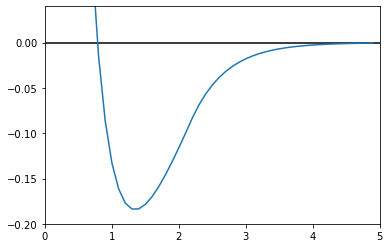

In [16]:
import matplotlib.pyplot as plt
plt.plot(distances, E_list)
plt.plot(distances, E_nuc, color="green")

plt.hlines(0, 0, 5, color="black")
plt.axis([0, 5, -0.2, 0.04])

In [17]:
E_H

-0.46658184955727544

iteration: 0, E_tot: -1.06599946, E_elek: -2.06599946, deltaE: -2.06599946, rmsD:  0.00000000


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-1.0659994621433029

2.356194490192345

-2.5223482699301996

iteration: 0, E_tot: -0.46658185, E_elek: -0.46658185, deltaE: -0.46658185, rmsD:  0.00000000


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


-0.46658184955727544

In [129]:
distances = np.arange(0.2, 5, 0.5)
E_list = []
E_nuc = []
E_elek = []
for distance in np.nditer(distances):
    specifications = "Cl 0.0000 0.0000 0.0000" +"\n" f"Cl {distance} 0.0000 0.0000"
    hydrogen = Molecule(specifications)
    hydrogen.setGuess()
    E = iterator(hydrogen)
    E_nuc.append(hydrogen.displayNucRep())
    E_list.append(E)
    E_elek.append(hydrogen.getElectronicEnergy())

/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:186: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:49: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -119.43658688, E_elek: -1564.43658688, deltaE: -1564.43658688, rmsD:  1167.05610887
iteration: 1, E_tot: -126.11671879, E_elek: -1571.11671879, deltaE: -6.68013190, rmsD:  9.12344568
iteration: 2, E_tot: -126.11786968, E_elek: -1571.11786968, deltaE: -0.00115089, rmsD:  0.02248995
iteration: 3, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE: -0.00000047, rmsD:  0.00242802
iteration: 4, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE: -0.00000000, rmsD:  0.00010961
iteration: 5, E_tot: -126.11787015, E_elek: -1571.11787015, deltaE:  0.00000000, rmsD:  0.00000369
iteration: 0, E_tot: -836.09473925, E_elek: -1248.95188210, deltaE: -1248.95188210, rmsD:  406.99638976
iteration: 1, E_tot: -839.05737689, E_elek: -1251.91451975, deltaE: -2.96263764, rmsD:  12.85076392
iteration: 2, E_tot: -839.08147453, E_elek: -1251.93861739, deltaE: -0.02409764, rmsD:  0.78662586
iteration: 3, E_tot: -839.08180671, E_elek: -1251.93894957, deltaE: -0.00033218, rmsD:  0.0150949

iteration: 4, E_tot: -909.10348298, E_elek: -977.91300678, deltaE: -0.00028903, rmsD:  0.02502204
iteration: 5, E_tot: -909.10352363, E_elek: -977.91304744, deltaE: -0.00004065, rmsD:  0.01562436
iteration: 6, E_tot: -909.10353057, E_elek: -977.91305438, deltaE: -0.00000694, rmsD:  0.00777135
iteration: 7, E_tot: -909.10353180, E_elek: -977.91305561, deltaE: -0.00000124, rmsD:  0.00353124
iteration: 8, E_tot: -909.10353202, E_elek: -977.91305583, deltaE: -0.00000022, rmsD:  0.00153366
iteration: 9, E_tot: -909.10353206, E_elek: -977.91305587, deltaE: -0.00000004, rmsD:  0.00064959
iteration: 10, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000001, rmsD:  0.00027111
iteration: 11, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000000, rmsD:  0.00011215
iteration: 12, E_tot: -909.10353207, E_elek: -977.91305588, deltaE: -0.00000000, rmsD:  0.00004614
iteration: 0, E_tot: -908.13399157, E_elek: -969.62335327, deltaE: -969.62335327, rmsD:  6.99606055
iteration: 1, E

iteration: 18, E_tot: -909.08412796, E_elek: -955.69703119, deltaE: -0.00000006, rmsD:  0.00042381
iteration: 19, E_tot: -909.08412797, E_elek: -955.69703120, deltaE: -0.00000001, rmsD:  0.00014401
iteration: 20, E_tot: -909.08412797, E_elek: -955.69703120, deltaE: -0.00000000, rmsD:  0.00004969
iteration: 0, E_tot: -908.36242421, E_elek: -951.49675257, deltaE: -951.49675257, rmsD:  4.09107813
iteration: 1, E_tot: -908.82783534, E_elek: -951.96216370, deltaE: -0.46541113, rmsD:  0.67629483
iteration: 2, E_tot: -908.84781255, E_elek: -951.98214090, deltaE: -0.01997720, rmsD:  0.09100107
iteration: 3, E_tot: -908.84919993, E_elek: -951.98352828, deltaE: -0.00138738, rmsD:  0.00816566
iteration: 4, E_tot: -908.84934675, E_elek: -951.98367510, deltaE: -0.00014682, rmsD:  0.01624367
iteration: 5, E_tot: -908.84937193, E_elek: -951.98370029, deltaE: -0.00002518, rmsD:  0.01045711
iteration: 6, E_tot: -908.84937719, E_elek: -951.98370555, deltaE: -0.00000526, rmsD:  0.00549402
iteration: 7, E

iteration: 1, E_tot: -908.84203688, E_elek: -942.06042768, deltaE: -0.35515683, rmsD:  0.50036855
iteration: 2, E_tot: -908.85364963, E_elek: -942.07204043, deltaE: -0.01161275, rmsD:  0.05959929
iteration: 3, E_tot: -908.85438336, E_elek: -942.07277416, deltaE: -0.00073373, rmsD:  0.01012504
iteration: 4, E_tot: -908.85445887, E_elek: -942.07284967, deltaE: -0.00007551, rmsD:  0.01294759
iteration: 5, E_tot: -908.85447136, E_elek: -942.07286217, deltaE: -0.00001249, rmsD:  0.00773854
iteration: 6, E_tot: -908.85447380, E_elek: -942.07286460, deltaE: -0.00000243, rmsD:  0.00655176
iteration: 7, E_tot: -908.85447719, E_elek: -942.07286800, deltaE: -0.00000339, rmsD:  0.05057091
iteration: 8, E_tot: -908.85531264, E_elek: -942.07370344, deltaE: -0.00083545, rmsD:  0.91825105
iteration: 9, E_tot: -908.94558839, E_elek: -942.16397919, deltaE: -0.09027575, rmsD:  2.07798583
iteration: 10, E_tot: -909.07699032, E_elek: -942.29538112, deltaE: -0.13140193, rmsD:  0.37039492
iteration: 11, E_to

iteration: 5, E_tot: -908.84230780, E_elek: -934.64587923, deltaE: -0.00008303, rmsD:  0.42130094
iteration: 6, E_tot: -908.88445779, E_elek: -934.68802921, deltaE: -0.04214999, rmsD:  2.60712296
iteration: 7, E_tot: -909.07712649, E_elek: -934.88069792, deltaE: -0.19266870, rmsD:  0.36903198
iteration: 8, E_tot: -909.08414148, E_elek: -934.88771291, deltaE: -0.00701500, rmsD:  0.05596153
iteration: 9, E_tot: -909.08432135, E_elek: -934.88789277, deltaE: -0.00017986, rmsD:  0.00919836
iteration: 10, E_tot: -909.08432596, E_elek: -934.88789738, deltaE: -0.00000461, rmsD:  0.00159647
iteration: 11, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000012, rmsD:  0.00030645
iteration: 12, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000000, rmsD:  0.00007017
iteration: 13, E_tot: -909.08432608, E_elek: -934.88789751, deltaE: -0.00000000, rmsD:  0.00002003
iteration: 0, E_tot: -908.60042097, E_elek: -933.30127567, deltaE: -933.30127567, rmsD:  2.18867299
iteration: 1, 

iteration: 4, E_tot: -909.08416882, E_elek: -928.74403277, deltaE: -0.01347300, rmsD:  0.05996448
iteration: 5, E_tot: -909.08436645, E_elek: -928.74423039, deltaE: -0.00019763, rmsD:  0.00746228
iteration: 6, E_tot: -909.08436972, E_elek: -928.74423366, deltaE: -0.00000327, rmsD:  0.00102542
iteration: 7, E_tot: -909.08436984, E_elek: -928.74423378, deltaE: -0.00000012, rmsD:  0.00017656
iteration: 8, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000001, rmsD:  0.00004369
iteration: 9, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000000, rmsD:  0.00001476
iteration: 10, E_tot: -909.08436985, E_elek: -928.74423380, deltaE: -0.00000000, rmsD:  0.00000580
iteration: 0, E_tot: -908.64659061, E_elek: -927.65974850, deltaE: -927.65974850, rmsD:  1.48576133
iteration: 1, E_tot: -908.82799826, E_elek: -927.84115615, deltaE: -0.18140765, rmsD:  0.63767064
iteration: 2, E_tot: -908.88750261, E_elek: -927.90066051, deltaE: -0.05950435, rmsD:  2.69557638
iteration: 3, E_t

iteration: 0, E_tot: -908.39653646, E_elek: -923.85108192, deltaE: -923.85108192, rmsD:  4.39388041
iteration: 1, E_tot: -909.08271821, E_elek: -924.53726367, deltaE: -0.68618175, rmsD:  0.00000322
iteration: 2, E_tot: -909.08418523, E_elek: -924.53873069, deltaE: -0.00146702, rmsD:  0.00000025
iteration: 3, E_tot: -909.08435271, E_elek: -924.53889817, deltaE: -0.00016748, rmsD:  0.00000001
iteration: 4, E_tot: -909.08438127, E_elek: -924.53892673, deltaE: -0.00002856, rmsD:  0.00000000
iteration: 5, E_tot: -909.08438625, E_elek: -924.53893170, deltaE: -0.00000497, rmsD:  0.00000000
iteration: 6, E_tot: -909.08438711, E_elek: -924.53893257, deltaE: -0.00000087, rmsD:  0.00000000
iteration: 7, E_tot: -909.08438726, E_elek: -924.53893272, deltaE: -0.00000015, rmsD:  0.00000000
iteration: 8, E_tot: -909.08438729, E_elek: -924.53893275, deltaE: -0.00000003, rmsD:  0.00000000
iteration: 9, E_tot: -909.08438730, E_elek: -924.53893275, deltaE: -0.00000000, rmsD:  0.00000000
iteration: 10, E_t

In [ ]:
import matplotlib.pyplot as plt
plt.plot(distances, E_list)
plt.plot(distances, E_elek, color="red")

In [145]:
E_list

[-126.11787014962852,
 -839.0818123840293,
 -892.3204141972739,
 -902.9619200785287,
 -906.9802214304929,
 -908.4772130007149,
 -908.978224318583,
 -909.1078788237857,
 -909.103532067438,
 -909.0573609659988,
 -909.0870044084412,
 -909.0848895765262,
 -909.0841279712454,
 -909.083933693559,
 -909.0839539773949,
 -909.0840337404597,
 -909.0841142398428,
 -909.084179318444,
 -909.084228264219,
 -909.0842643695248,
 -909.0842910636476,
 -909.0843110032102,
 -909.0843260813427,
 -909.0843376220416,
 -909.0843465555743,
 -909.084353543635,
 -909.0843590626747,
 -909.0843634604234,
 -909.0843669939395,
 -909.0843698548227,
 -909.0843721878464,
 -909.0843741031406,
 -909.084375685394,
 -909.0843770002825,
 -909.0843780988654,
 -909.0843880172145,
 -909.0843876270307,
 -909.0843872961796,
 -909.084384035771,
 -909.0843845772878]

In [102]:
psi4.set_options({'basis': '6-31G*'})
oxygen = Molecule("""pubchem:oxygen""")
oxygen.setGuess()
iterator(oxygen)

	Searching PubChem database for oxygen (single best match returned)
	Found 1 result(s)


/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:183: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/usr/local/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


iteration: 0, E_tot: -140.63821919, E_elek: -168.12794442, deltaE: -168.12794442, rmsD:  44.10307070
iteration: 1, E_tot: -148.49434055, E_elek: -175.98406578, deltaE: -7.85612137, rmsD:  12.61808497
iteration: 2, E_tot: -149.25358156, E_elek: -176.74330679, deltaE: -0.75924101, rmsD:  3.41584212
iteration: 3, E_tot: -149.32437379, E_elek: -176.81409902, deltaE: -0.07079223, rmsD:  1.09873535
iteration: 4, E_tot: -149.33249922, E_elek: -176.82222445, deltaE: -0.00812543, rmsD:  0.37328518
iteration: 5, E_tot: -149.33355145, E_elek: -176.82327668, deltaE: -0.00105223, rmsD:  0.13317695
iteration: 6, E_tot: -149.33370713, E_elek: -176.82343236, deltaE: -0.00015568, rmsD:  0.05338514
iteration: 7, E_tot: -149.33373314, E_elek: -176.82345837, deltaE: -0.00002601, rmsD:  0.02281619
iteration: 8, E_tot: -149.33373791, E_elek: -176.82346314, deltaE: -0.00000477, rmsD:  0.00994806
iteration: 9, E_tot: -149.33373883, E_elek: -176.82346406, deltaE: -0.00000093, rmsD:  0.00438698
iteration: 10, E

-149.33373906923083